In [290]:
import warnings
warnings.simplefilter("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import pmdarima as pm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from scipy.interpolate import make_interp_spline

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Simhei']
plt.rcParams['figure.figsize'] = 20, 6

In [158]:
data = pd.read_excel("Problem_C_Data_Wordle.xlsx", header=1)
data = data.drop(["Unnamed: 0"], axis=1)
data = data.sort_values(by="Date", axis=0, ascending=True)
data["value"] = data["Number_of_reported_results"]
data["date"] = data["Date"]
data.index = data["date"]
data = data.loc[:,["value"]]
data

,value
date,
2022-01-07,80630
2022-01-08,101503
2022-01-09,91477
2022-01-10,107134
2022-01-11,153880
...,...
2022-12-27,20879
2022-12-28,20160
2022-12-29,20001


In [272]:
data_value_transform = data
data_value_transform["transform"] = data_value_transform["value"].apply(np.log1p)
data_value_transform_diff_start = data_value_transform["transform"][0]
data_value_transform["transform"] = data_value_transform["transform"].diff()
data_value_transform = data_value_transform[(data_value_transform["transform"] < 1) & (data_value_transform["transform"] > -1)]
data_value_transform

,value,transform
date,,
2022-01-08,101503,0.230215
2022-01-09,91477,-0.104000
2022-01-10,107134,0.157991
2022-01-11,153880,0.362090
2022-01-12,137586,-0.111923
...,...,...
2022-12-27,20879,0.042460
2022-12-28,20160,-0.035042
2022-12-29,20001,-0.007918


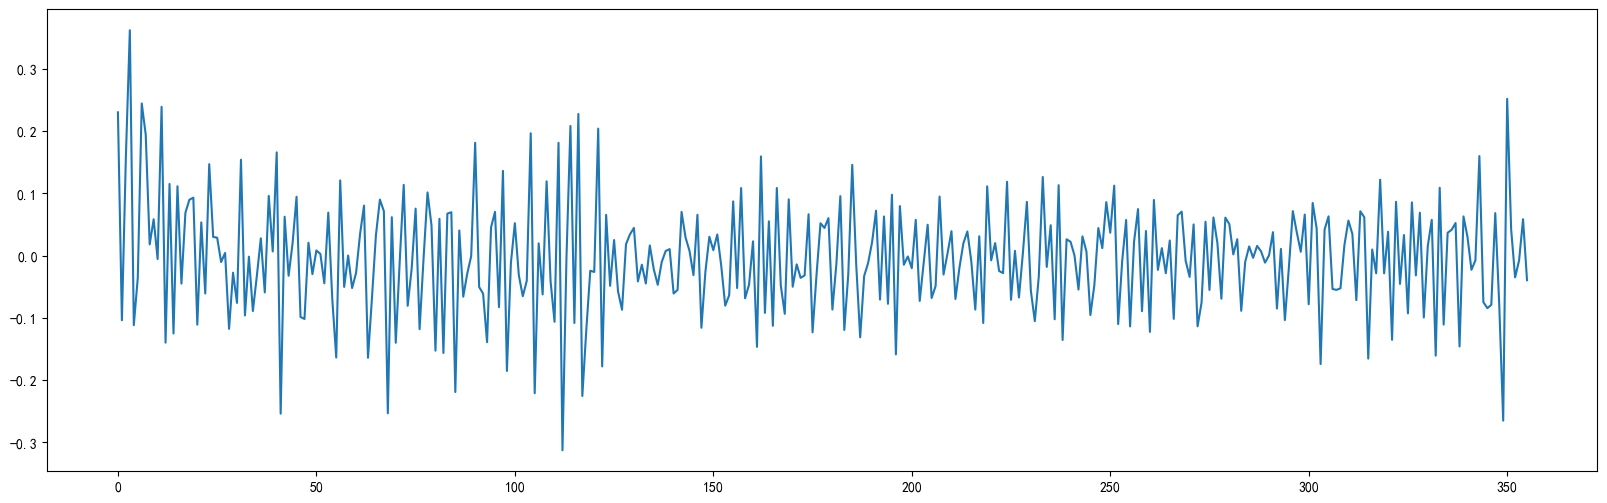

In [160]:
# data_value_transform = data_value_transform[(data_value_transform < 1) & (data_value_transform > -1)]

plt.plot(data_value_transform["transform"].tolist())
plt.show()

In [161]:
# ADF检验 判断是平稳序列

results = adfuller(data_value_transform["transform"].tolist())
print("ADF Statistic: ", results[0])
print("p value: ", results[1])

ADF Statistic:  -5.774827057981027
p value:  5.289194055735223e-07


In [162]:
data_value_transform_list = data_value_transform["transform"]
train = data_value_transform_list['2022-01-08':'2022-12-31']
test = data_value_transform_list['2022-12-01':'2022-12-31']
train

date
2022-01-08    0.230215
2022-01-09   -0.104000
2022-01-10    0.157991
2022-01-11    0.362090
2022-01-12   -0.111923
                ...   
2022-12-27    0.042460
2022-12-28   -0.035042
2022-12-29   -0.007918
2022-12-30    0.058405
2022-12-31   -0.039634
Name: transform, Length: 356, dtype: float64

In [108]:
model = pm.auto_arima(train, stepwise=False, start_p=1, start_q=1, start_d=1, max_p=10, max_q=10, max_d=5)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  357
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 392.574
Date:                Sun, 19 Feb 2023   AIC                           -775.148
Time:                        13:28:18   BIC                           -755.759
Sample:                             0   HQIC                          -767.436
                                - 357                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.509      0.611      -0.000       0.001
ar.L1          0.9806      0.010    101.637      0.000       0.962       0.999
ma.L1         -1.5333      0.038    -40.300      0.000      -1.608      -1.459
ma.L2          0.5893      0.037     15.857      0.000       0.516       0.662
sigma2         0.0063      0.000     15.695      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):                36.17
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [163]:
model = ARIMA(train, order=(1, 0, 2)).fit()
model.summary()

D:\anaconda3\envs\study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda3\envs\study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda3\envs\study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              transform   No. Observations:                  356
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 391.515
Date:                Sun, 19 Feb 2023   AIC                           -773.031
Time:                        13:49:40   BIC                           -753.656
Sample:                             0   HQIC                          -765.324
                                - 356                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0142      0.021      0.674      0.500      -0.027       0.055
ar.L1          0.9921      0.005    204.809      0.000       0.983       1.002
ma.L1         -1.5590      0.037    -42.463      0.000      -1.631      -1.487
ma.L2          0.6124      0.036     16.803      0.000       0.541       0.684
sigma2         0.0065      0.000     14.964      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                15.43
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [211]:
forecast = model.get_forecast(91)
forecast.conf_int()

D:\anaconda3\envs\study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,lower transform,upper transform
356,-0.170595,0.144279
357,-0.183475,0.178471
358,-0.183514,0.178773
359,-0.183552,0.179072
360,-0.183588,0.179366
...,...,...
442,-0.183192,0.194521
443,-0.183168,0.194630
444,-0.183143,0.194739
445,-0.183118,0.194846


In [216]:
forecast_result = pd.DataFrame()
forecast_result["lower_forecast"] = forecast.conf_int()["lower transform"]
forecast_result["upper_forecast"] = forecast.conf_int()["upper transform"]
forecast_result["average_forecast"] = (forecast_result["lower_forecast"] + forecast_result["upper_forecast"]) / 2
forecast_result["date"] = pd.date_range("2022-12-01", "2023-03-01")
forecast_result.index = forecast_result["date"]
forecast_result["actual_result"] = data["value"]
forecast_result.head(32)

,lower_forecast,upper_forecast,average_forecast,date,actual_result
date,,,,,
2022-12-01,-0.170595,0.144279,-0.013158,2022-12-01,22628.0
2022-12-02,-0.183475,0.178471,-0.002502,2022-12-02,24646.0
2022-12-03,-0.183514,0.178773,-0.002370,2022-12-03,23873.0
2022-12-04,-0.183552,0.179072,-0.002240,2022-12-04,25577.0
2022-12-05,-0.183588,0.179366,-0.002111,2022-12-05,23153.0
2022-12-06,-0.183622,0.179657,-0.001982,2022-12-06,23509.0
2022-12-07,-0.183654,0.179944,-0.001855,2022-12-07,24899.0
2022-12-08,-0.183685,0.180228,-0.001729,2022-12-08,21199.0
2022-12-09,-0.183714,0.180507,-0.001603,2022-12-09,23640.0


In [273]:
data_value_transform_diff_start = data_value_transform_diff_start + data_value_transform['2022-01-08':'2022-11-30']["transform"].sum()
data_value_transform_diff_start

10.07491666816366

In [225]:
forecast_result["average_forecast_result"] = forecast_result["average_forecast"].cumsum() + data_value_transform_diff_start
forecast_result["average_forecast_result"] = forecast_result["average_forecast_result"].apply(np.expm1)

forecast_result["lower_forecast_result"] = forecast_result["average_forecast"].cumsum() + data_value_transform_diff_start - forecast_result["average_forecast"] + forecast_result["lower_forecast"]
forecast_result["lower_forecast_result"] = forecast_result["lower_forecast_result"].apply(np.expm1)

forecast_result["upper_forecast_result"] = forecast_result["average_forecast"].cumsum() + data_value_transform_diff_start - forecast_result["average_forecast"] + forecast_result["upper_forecast"]
forecast_result["upper_forecast_result"] = forecast_result["upper_forecast_result"].apply(np.expm1)

forecast_result

,lower_forecast,upper_forecast,average_forecast,date,actual_result,average_forecast_result,lower_forecast_result,upper_forecast_result
date,,,,,,,,
2022-12-01,-0.170595,0.144279,-0.013158,2022-12-01,22628.0,23428.672713,20015.681185,27423.604427
2022-12-02,-0.183475,0.178471,-0.002502,2022-12-02,24646.0,23370.128982,19501.225867,28006.555324
2022-12-03,-0.183514,0.178773,-0.002370,2022-12-03,23873.0,23314.795187,19451.728566,27945.018131
2022-12-04,-0.183552,0.179072,-0.002240,2022-12-04,25577.0,23262.625135,19404.941758,27887.172662
2022-12-05,-0.183588,0.179366,-0.002111,2022-12-05,23153.0,23213.574334,19360.825639,27832.969354
...,...,...,...,...,...,...,...,...
2023-02-25,-0.183192,0.194521,0.005664,2023-02-25,NaN,27896.833826,23095.769002,33695.883408
2023-02-26,-0.183168,0.194630,0.005731,2023-02-26,NaN,28057.184588,23227.531729,33891.013993
2023-02-27,-0.183143,0.194739,0.005798,2023-02-27,NaN,28220.336310,23361.617761,34089.521503


In [248]:
forecast_result_test = pd.concat([forecast_result["2022-12-01":"2022-12-24"], forecast_result["2022-12-27":"2022-12-31"]])
print("RMSE:", np.sqrt(mean_squared_error(forecast_result_test["actual_result"], forecast_result_test["average_forecast_result"])))

RMSE: 1664.530656633322


In [313]:
forecast_result = pd.DataFrame()
forecast_result["date"] = pd.date_range("2022-12-01", "2022-12-31")
forecast_result.index = forecast_result["date"]
forecast_result["actual_result"] = data["value"]

rmse_matrix = np.zeros((10, 10))
# print(rmse_matrix)

for p in range(10):
    for q in range(10):
        model = ARIMA(train, order=(p, 0, q)).fit()
        forecast = model.forecast(31)
        forecast.index = forecast_result["date"]
        forecast_result["predicted_mean"] = forecast.values
        
        forecast_result["predicted_result"] = forecast_result["predicted_mean"].cumsum() + data_value_transform_diff_start
        forecast_result["predicted_result"] = forecast_result["predicted_result"].apply(np.expm1)
        # print(forecast_result)
        
        rmse = np.sqrt( mean_squared_error(forecast_result["actual_result"], forecast_result["predicted_result"]) )   
        rmse_matrix[p][q] = rmse

rmse_matrix

array([[   0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ],
       [   0.      ,    0.      , 1706.754993,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ],
       [   0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ],
       [   0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ],
       [   0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ],
       [   0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ],
       [   0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      

In [287]:
# rmse_matrix_csv = pd.DataFrame(rmse_matrix, columns=[i for i in range(10)])
rmse_matrix_csv.to_csv("sensitive_analyse_rmse_matrix.csv")
rmse_matrix_csv

,0,1,2,3,4,5,6,7,8,9
0,1706.754993,1690.898527,1701.818712,1718.885792,1902.847465,2570.594966,2788.320801,2726.137636,2720.576747,2656.042285
1,1728.338072,1699.183313,2135.195994,1980.993775,3191.427417,2840.370318,2783.229442,2715.502148,2727.774201,2651.890229
2,1708.630095,1701.393173,1949.331846,2490.219624,2018.424256,2618.197984,1736.405677,2651.279370,2715.862119,2589.820500
3,1701.869118,1701.104005,1704.157740,2423.671482,2171.620052,2816.968596,2572.087571,2605.317271,2673.867865,2469.639317
4,1699.369866,2394.022587,1768.279840,2342.030049,2706.372857,2693.944554,1740.987415,2890.689360,2658.547349,2623.408133
5,1729.199320,2492.789776,2194.769540,2120.594841,2457.449231,1757.445764,1896.522990,1952.446580,1672.676156,2796.202914
6,1894.339256,2585.189272,2471.533443,2468.127175,2537.799340,1745.301253,2638.155208,1913.951593,1806.776883,2948.844169
7,2370.251980,2613.248919,2483.400077,2526.106511,2852.445272,2252.318995,2725.716650,2739.206636,1786.470515,2081.442296
8,2913.136096,2886.444040,2493.387396,2247.853936,2292.582980,2472.857676,2538.069085,3019.171484,2983.738137,1811.223006
9,3543.770940,2814.086278,2082.050614,2282.451507,2342.024476,2596.167112,2654.828377,2989.337143,3037.121828,3074.861242


<Figure size 1000x400 with 0 Axes>

Text(0.5, 0, 'parameter q')

Text(0, 0.5, 'RMSE')

Text(0.5, 1.0, '1')

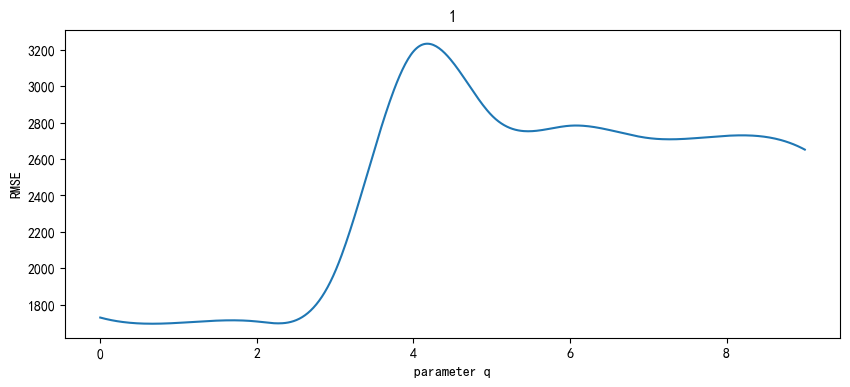

In [320]:
# 固定p=1
x = [i for i in range(10)]
y = rmse_matrix_csv.iloc[1,:].tolist()
y[2] = 1706.754993

model = make_interp_spline(x, y)

xs = np.linspace(0, 9, 500)
ys = model(xs)
# xs = x
# ys = y

plt.figure(figsize=(10, 4))
plt.xlabel("parameter q")
plt.ylabel("RMSE")
plt.plot(xs, ys)
plt.title("")
plt.show()

<Figure size 1000x400 with 0 Axes>

Text(0.5, 0, 'p')

Text(0, 0.5, 'RMSE')

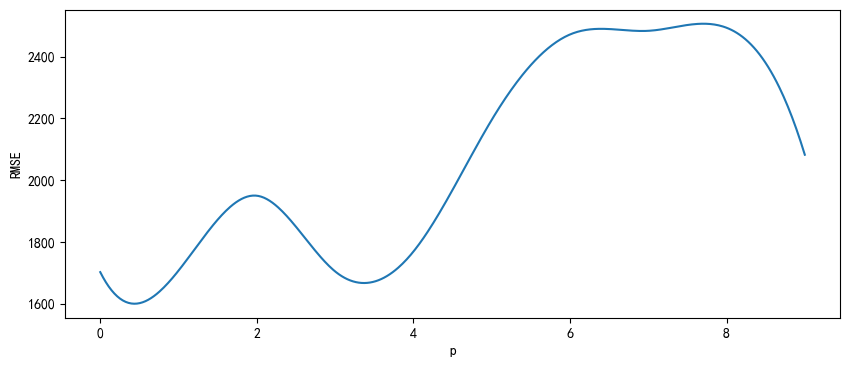

In [319]:
# 固定q=2
x = [i for i in range(10)]
y = rmse_matrix_csv.iloc[:,2].tolist()
y[1] = 1706.754993

model = make_interp_spline(x, y)

xs = np.linspace(0, 9, 500)
ys = model(xs)
# xs = x
# ys = y

plt.figure(figsize=(10, 4))
plt.xlabel("p")
plt.ylabel("RMSE")
plt.plot(xs, ys)
plt.show()